## Installing Necessary Libraries

In [1]:
!pip install split-folders
!pip install pathlib

## Importing Necessary Libraries

In [2]:
import tensorflow as tf
tf.random.set_seed(42)
import keras
import matplotlib.pyplot as plt
import os
import pathlib
import splitfolders
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Splitting the data in Train-Test-Validation set

In [3]:
root_path = '../input/rice-image-dataset/Rice_Image_Dataset'
root_path = pathlib.Path (root_path)

In [4]:
splitfolders.ratio(root_path, output='Images', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 75000 files [13:17, 94.00 files/s] 


In [5]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

train_generator = data_generator.flow_from_directory(
    directory = '/kaggle/working/Images/train',
    class_mode = 'categorical',
    seed = 42,
    target_size = (224, 224),
)
valid_generator = data_generator.flow_from_directory(
    directory = '/kaggle/working/Images/val',
    class_mode = 'categorical',
    seed = 42,
    target_size = (224, 224),
)
test_generator = data_generator.flow_from_directory(
    directory = '/kaggle/working/Images/test',
    class_mode = 'categorical',
    seed = 42,
    target_size = (224, 224),
)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


## Creating a custom CNN model

In [6]:
model = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=(224,224,3)),
    keras.layers.ZeroPadding2D(padding=(1,1)),
    
    keras.layers.Conv2D(filters=32, activation='relu', kernel_initializer = 'he_normal', kernel_size=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.ZeroPadding2D(padding=(1,1)),
    
    keras.layers.Conv2D(filters=64, activation='relu', kernel_initializer = 'he_normal', kernel_size=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 114, 114, 32)     0         
 ng2D)                                                  

In [7]:
cb_earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
cb_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='../working/mymodel.hdf5', monitor='val_loss', save_best_only=True, mode='auto', verbose=1)
cb_reducelor = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, mode='auto')

CALLBACKS = [cb_earlystopper, cb_checkpointer, cb_reducelor]

In [8]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=CALLBACKS
)

Epoch 1/20
1641/1641 [==============================] - ETA: 0s - loss: 1.2749 - accuracy: 0.8621
Epoch 1: val_loss improved from inf to 0.12712, saving model to ../working/mymodel.hdf5
1641/1641 [==============================] - 130s 73ms/step - loss: 1.2749 - accuracy: 0.8621 - val_loss: 0.1271 - val_accuracy: 0.9612 - lr: 0.0010
Epoch 2/20
1641/1641 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9490
Epoch 2: val_loss did not improve from 0.12712
1641/1641 [==============================] - 119s 72ms/step - loss: 0.2286 - accuracy: 0.9490 - val_loss: 0.7576 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 3/20
1641/1641 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9549
Epoch 3: val_loss did not improve from 0.12712

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1641/1641 [==============================] - 128s 78ms/step - loss: 0.2134 - accuracy: 0.9549 - val_loss: 1.7585 - val_accuracy: 0.7929 - lr: 0.0010

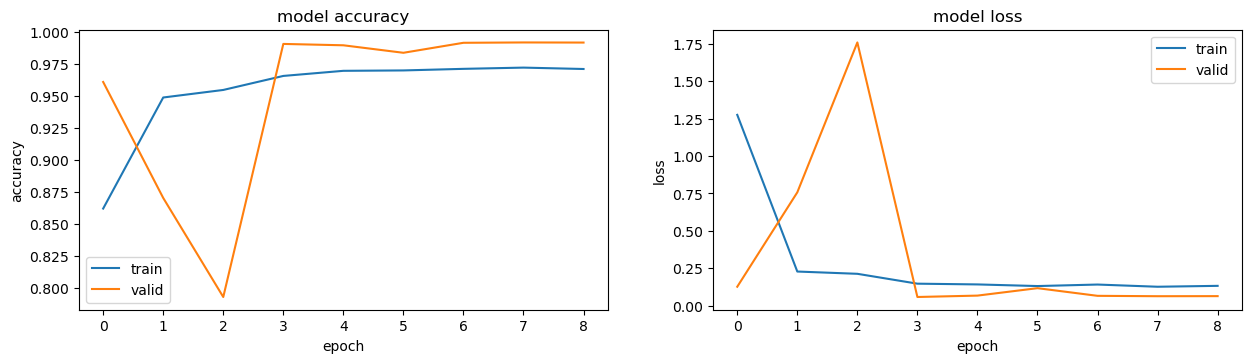

In [9]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [10]:
mymodel = tf.keras.models.load_model('../working/mymodel.hdf5')

mymodel.evaluate(test_generator, verbose = 1)


352/352 [==============================] - 18s 51ms/step - loss: 0.0611 - accuracy: 0.9890


[0.06105906516313553, 0.9889777898788452]